In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [5]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [6]:
dim = 8
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)

In [7]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

# Vanilla IS

In [8]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
    print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
          var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.0004944682450771503,           var is 2.0215767185375028e-05


# DReG likelihood

In [9]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type=False, n_distributions=10, n_steps_transition_operator=3,
                    step_size=1.0, transition_operator="HMC", learnt_dist_kwargs={"lr": 5e-4},
                     loss_type_2="alpha_2")

In [10]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.000978796613384147


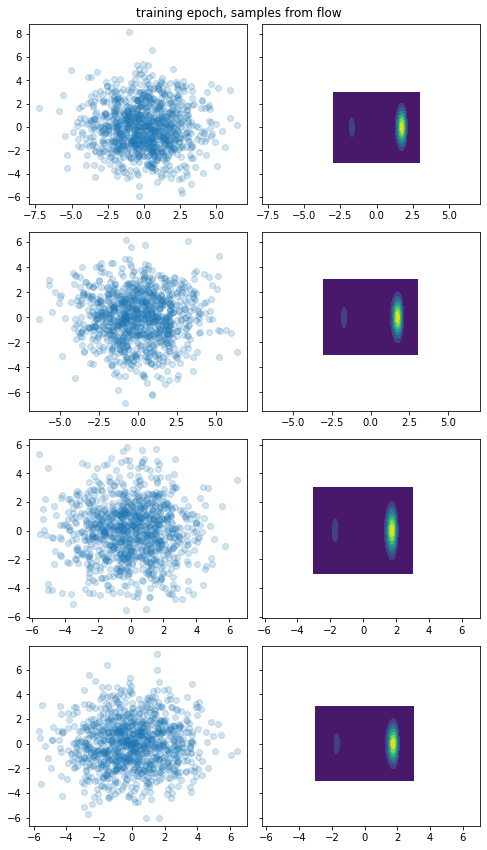

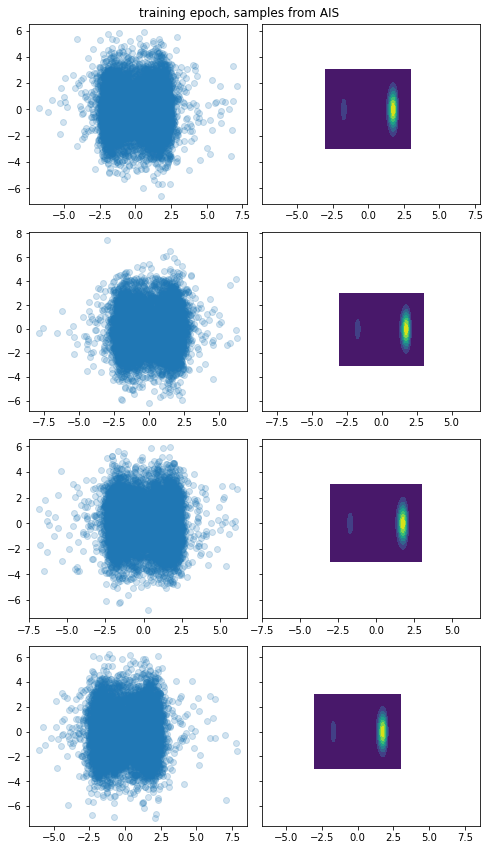

In [11]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

  0%|          | 0/2000 [00:00<?, ?it/s]

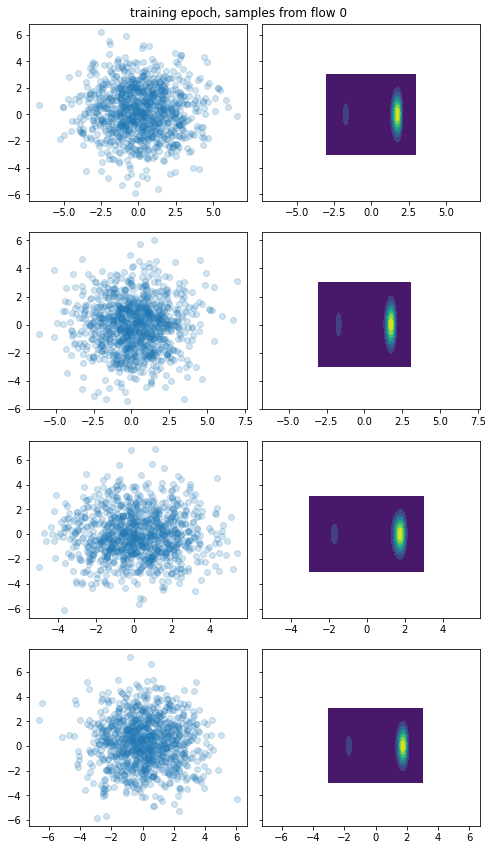

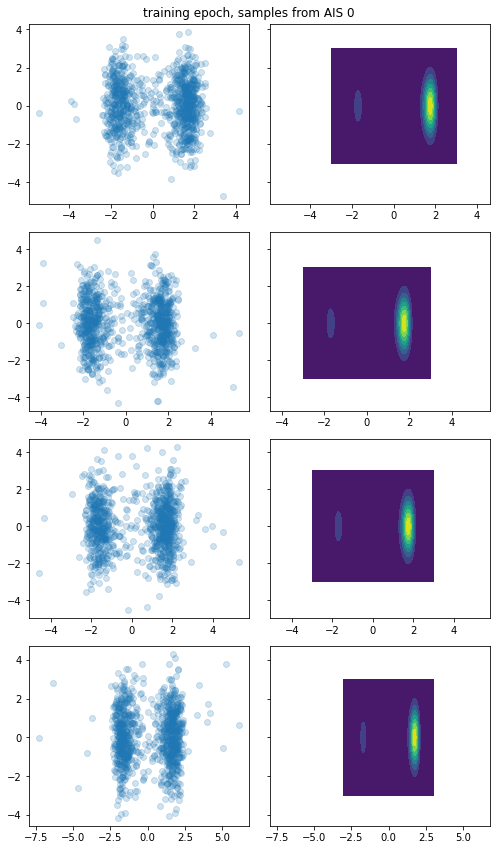

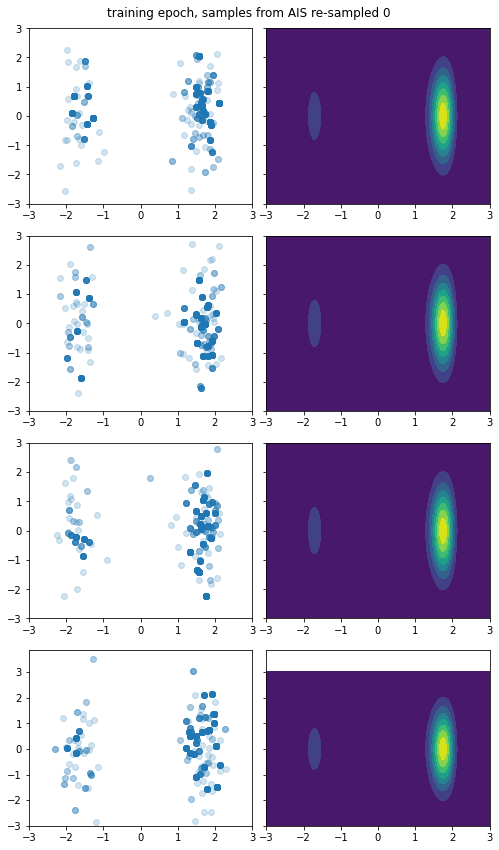

loss: 93.90913155955667,   log_p_x_post_AIS nan, ESS 0.12887450211981638:  10%|█         | 200/2000 [48:59<5:52:55, 11.76s/it]               

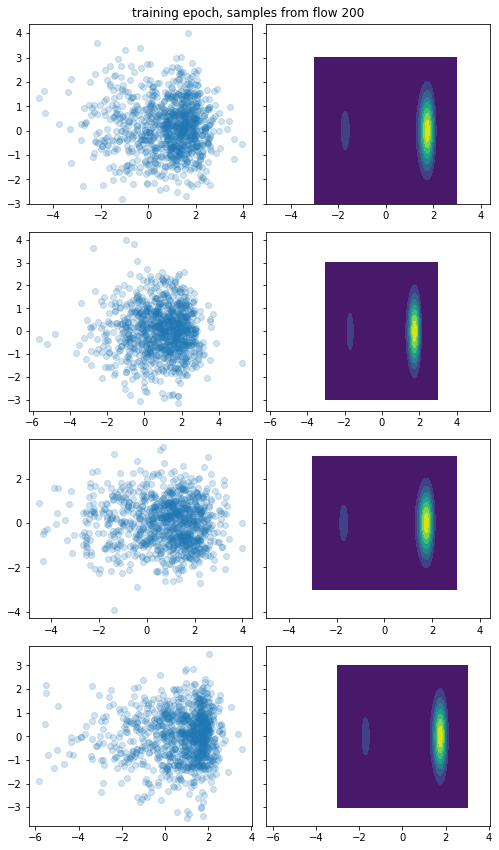

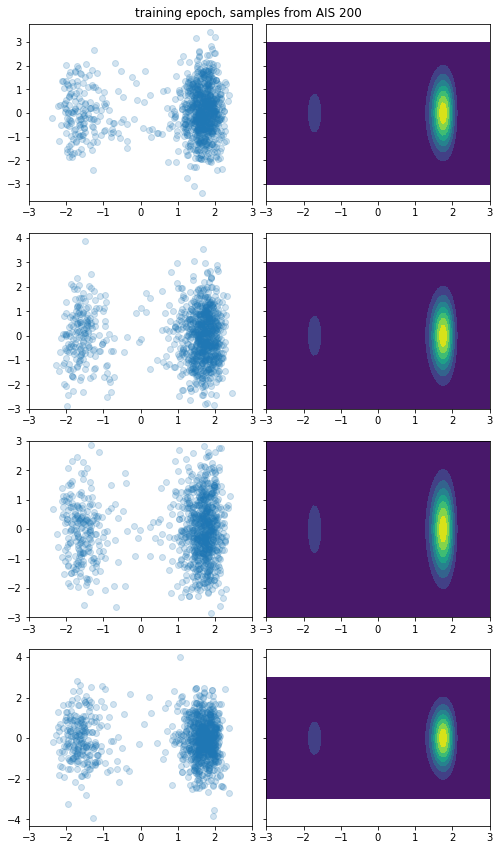

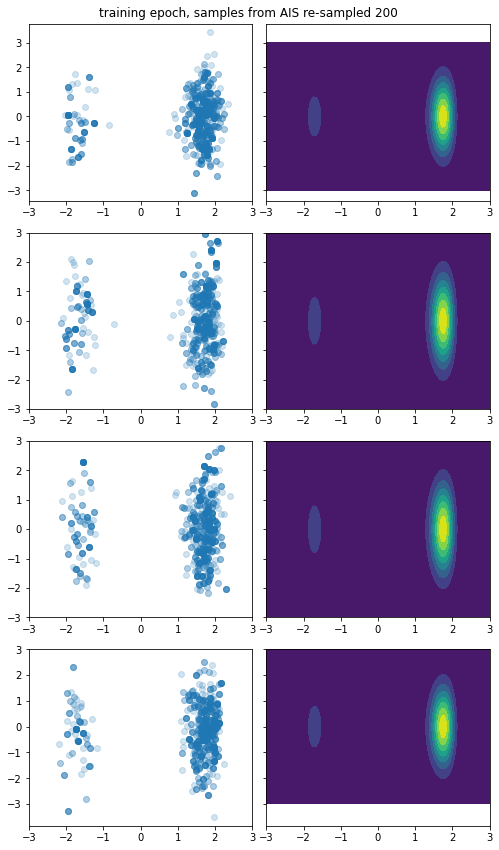

loss: 92.966533822886,   log_p_x_post_AIS nan, ESS 0.1298877478350172:  20%|██        | 400/2000 [1:28:20<5:12:32, 11.72s/it]   

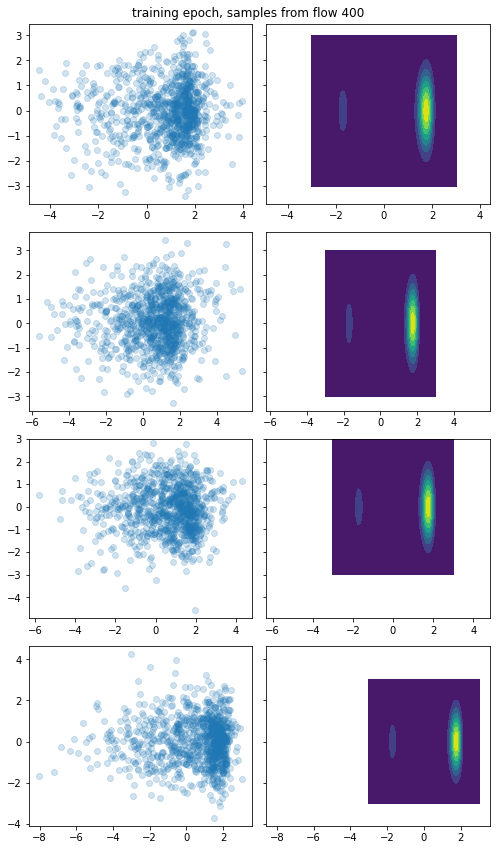

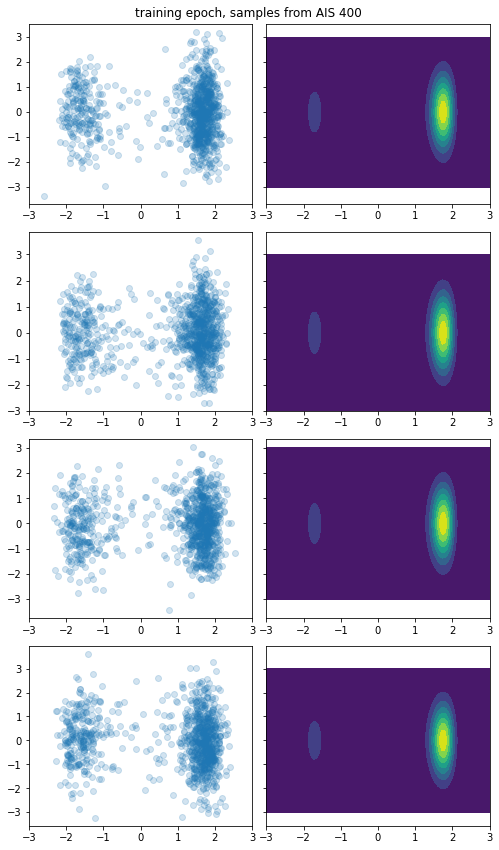

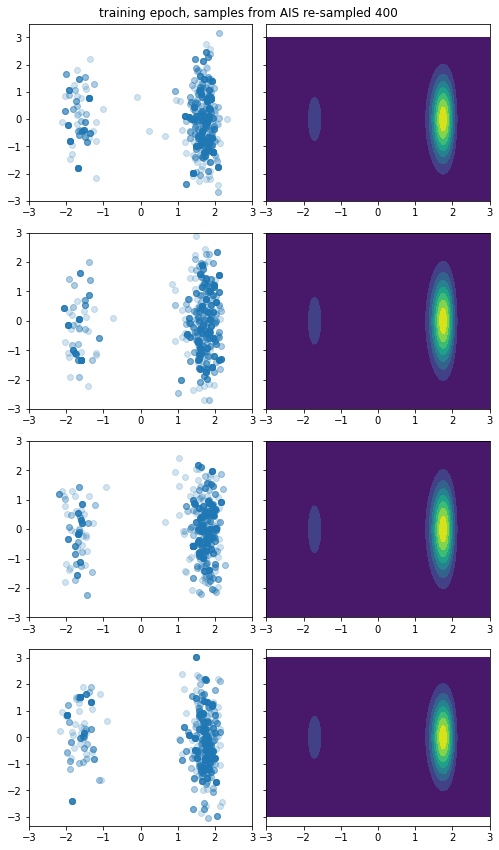

loss: 92.72861322366644,   log_p_x_post_AIS nan, ESS 0.1255396085126334:  30%|███       | 600/2000 [2:07:41<4:34:56, 11.78s/it] 

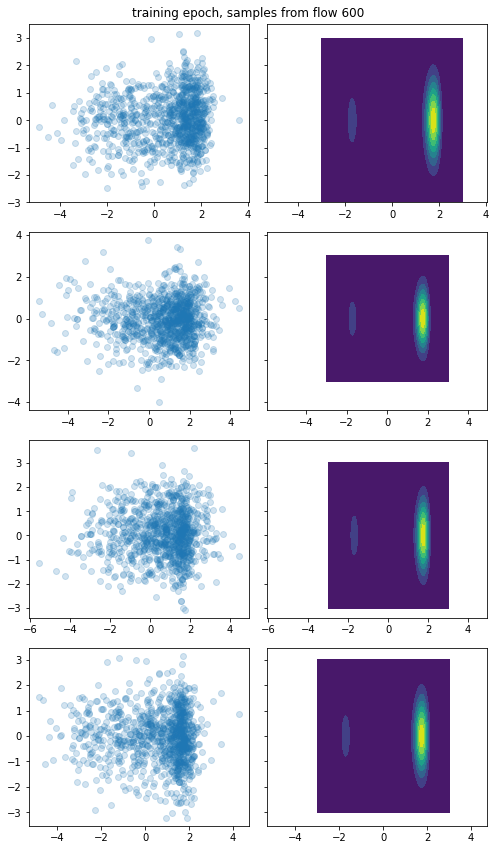

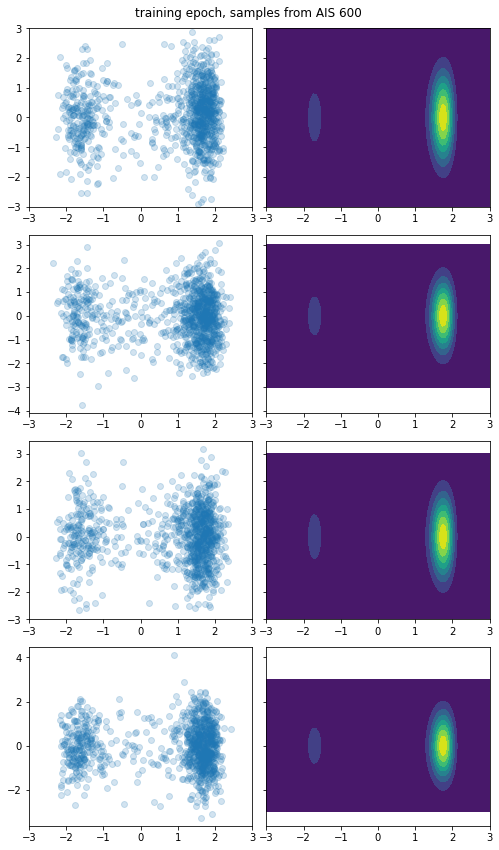

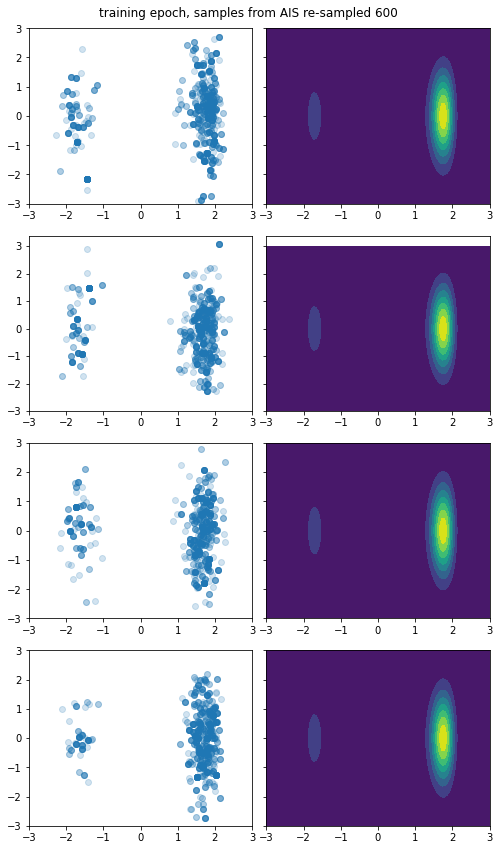

loss: 92.84638966579084,   log_p_x_post_AIS nan, ESS 0.10903693050408239:  40%|████      | 800/2000 [2:47:05<3:55:36, 11.78s/it]

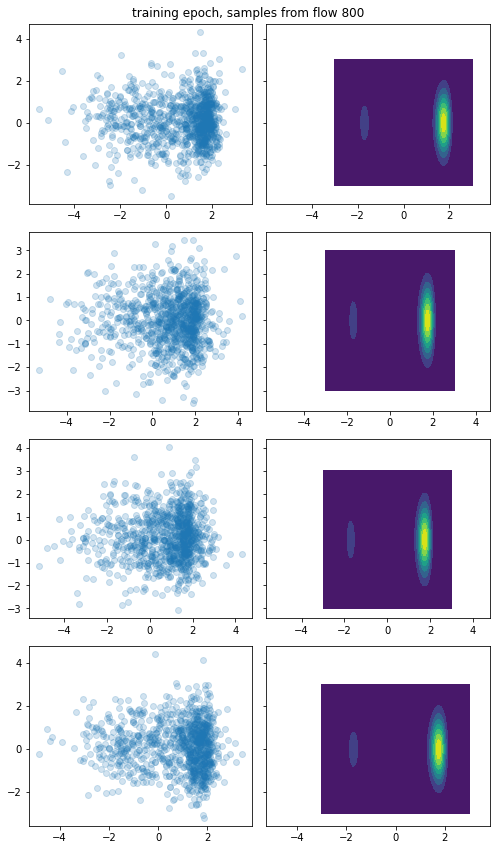

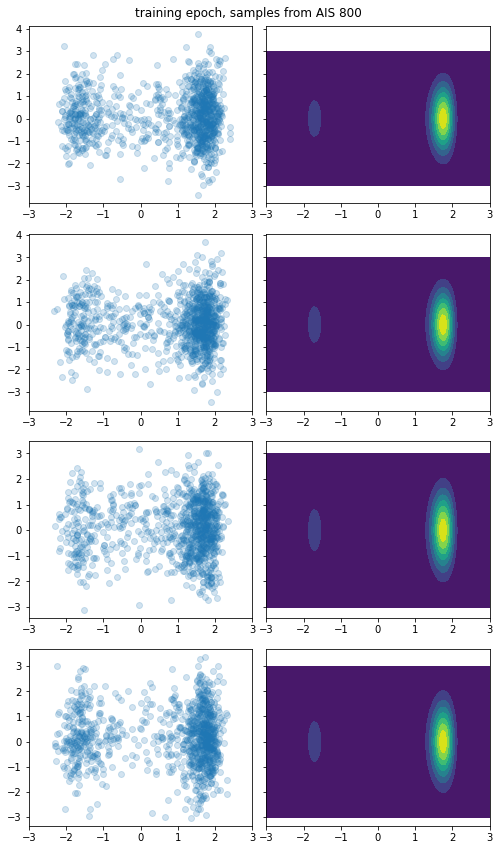

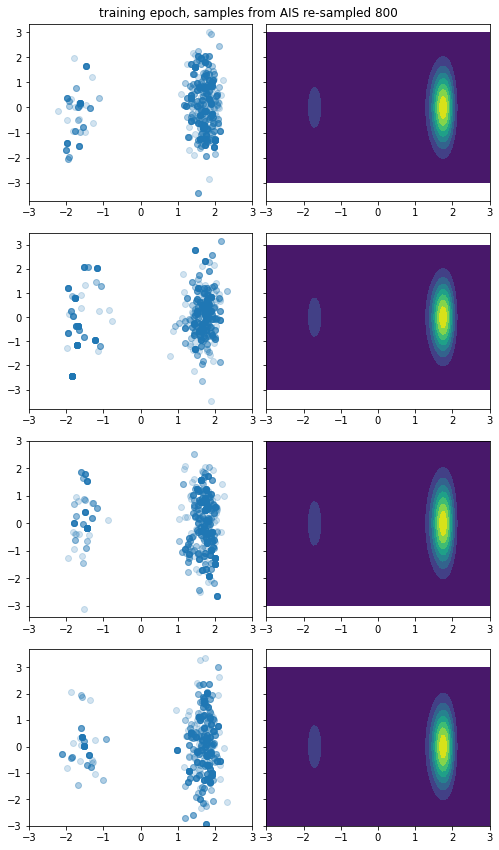

loss: 92.52942090966023,   log_p_x_post_AIS nan, ESS 0.09117303396058443:  50%|█████     | 1000/2000 [3:26:26<3:16:16, 11.78s/it]

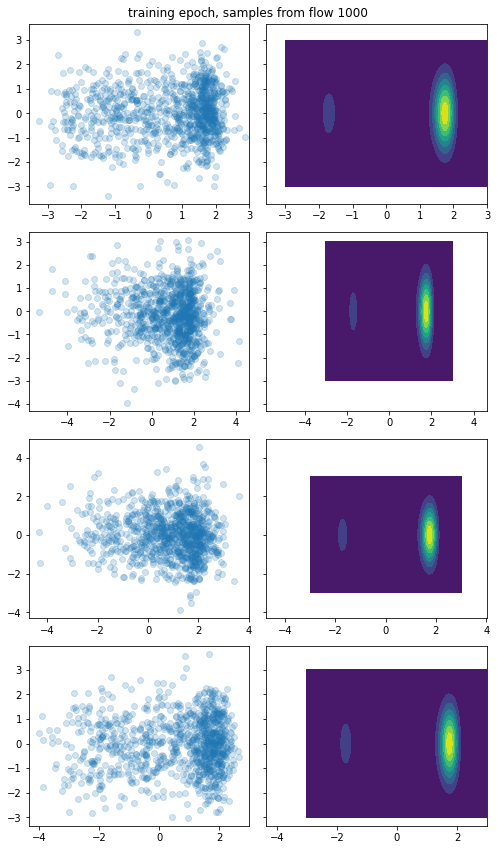

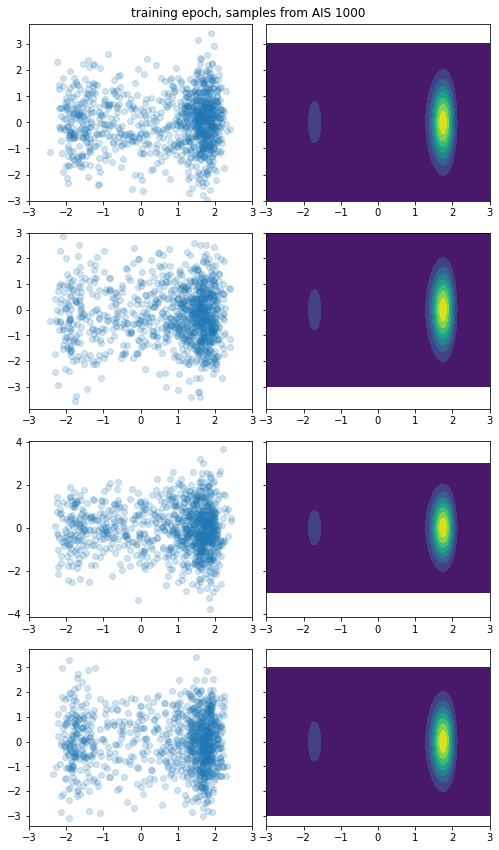

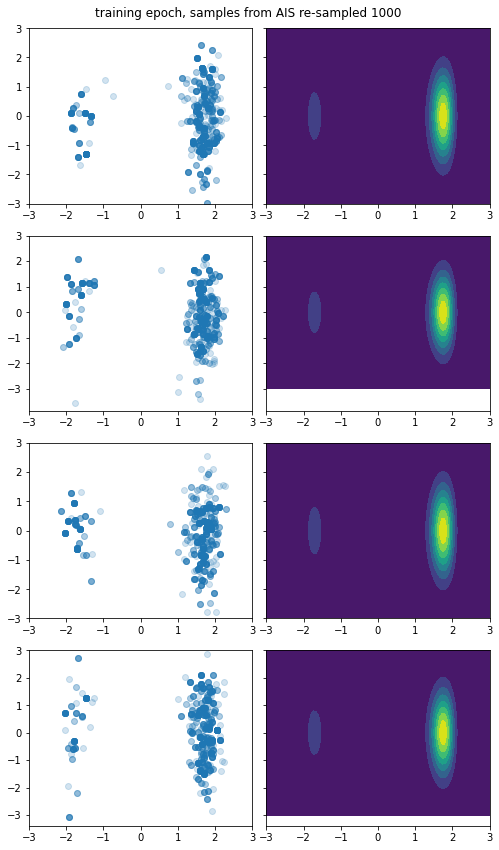

loss: 92.68514974219573,   log_p_x_post_AIS nan, ESS 0.10249951625942097:  60%|██████    | 1200/2000 [4:05:43<2:34:56, 11.62s/it]

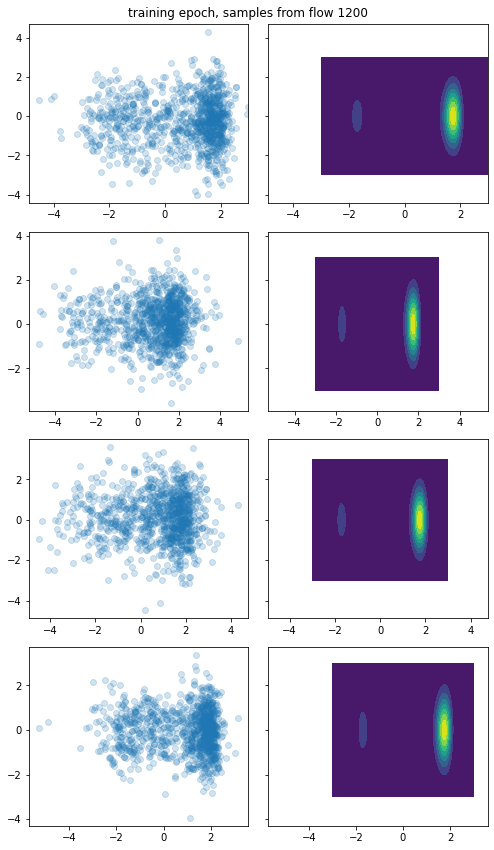

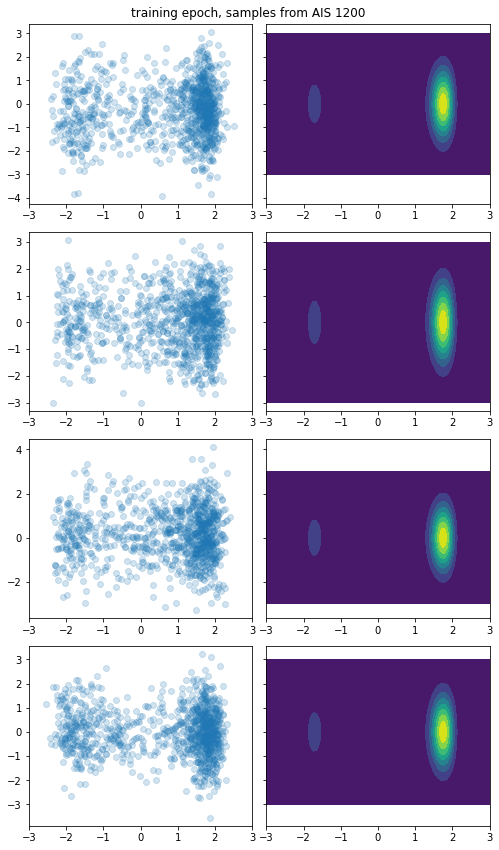

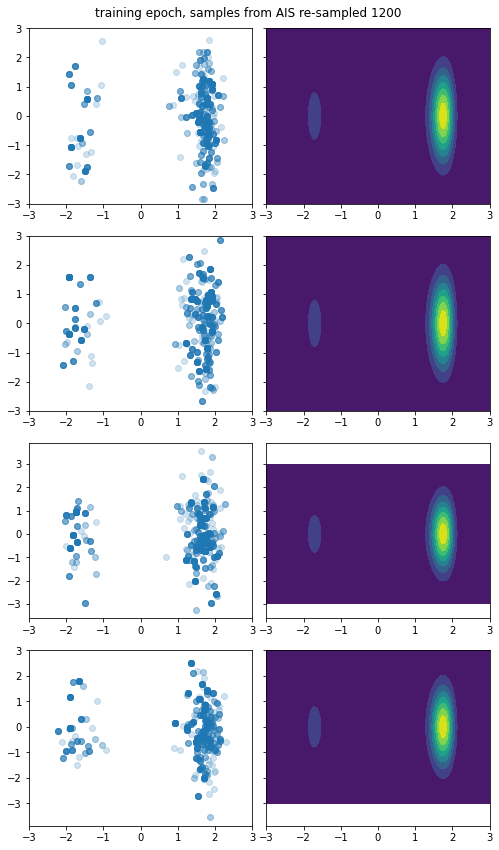

loss: 92.08705181425786,   log_p_x_post_AIS nan, ESS 0.1802843741976199:  70%|███████   | 1400/2000 [4:45:06<1:58:39, 11.87s/it] 

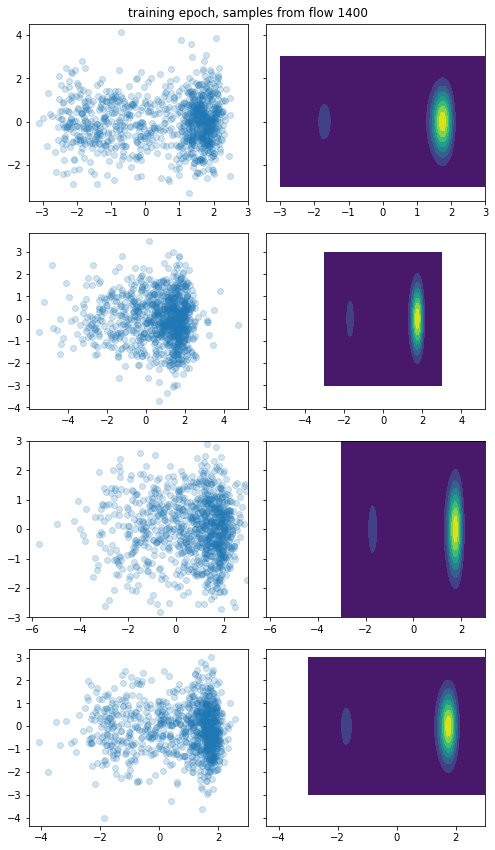

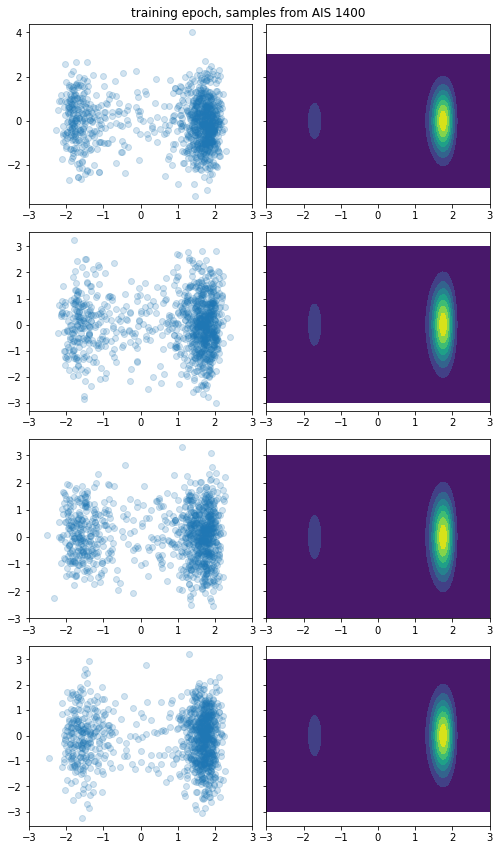

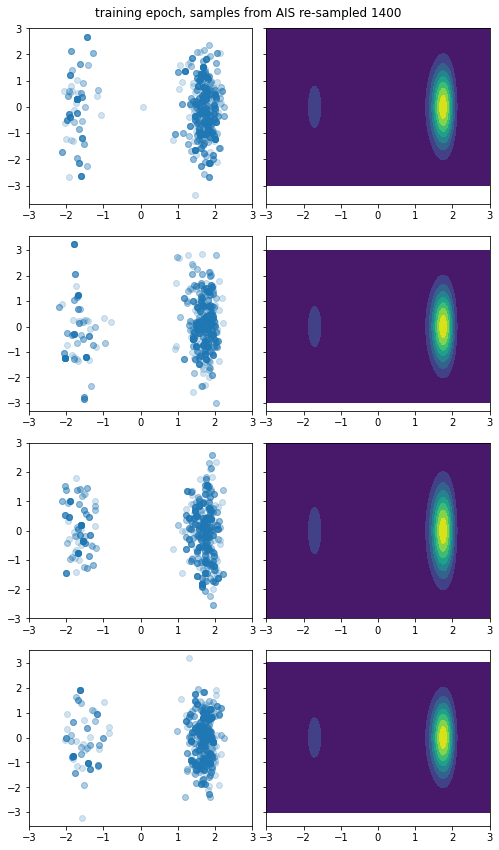

loss: 92.22894648304433,   log_p_x_post_AIS nan, ESS 0.18380414299033535:  80%|████████  | 1600/2000 [5:24:25<1:18:10, 11.73s/it]

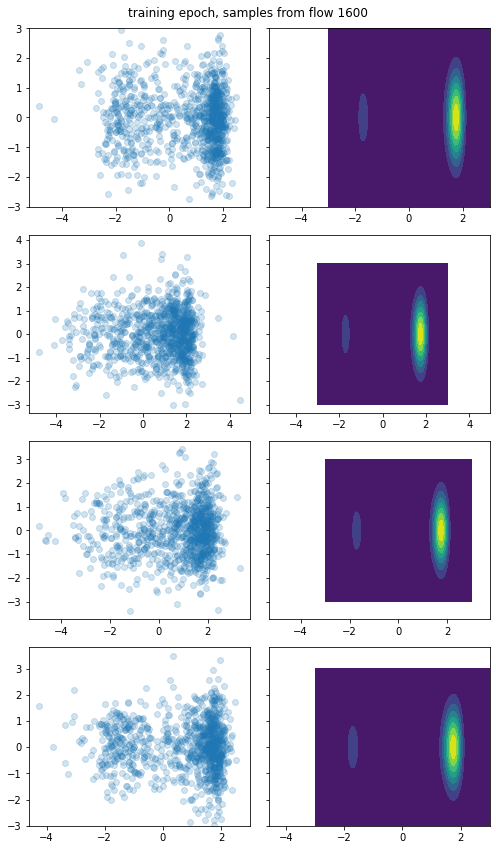

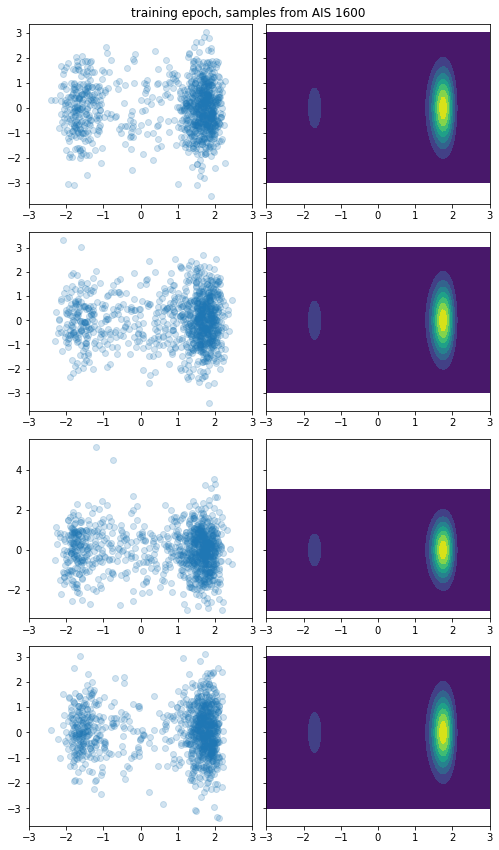

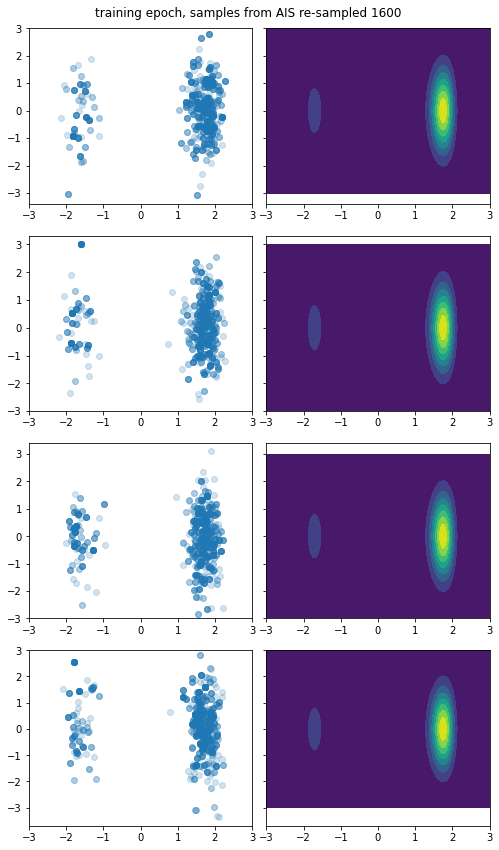

loss: 91.74710902195245,   log_p_x_post_AIS nan, ESS 0.267430710454299:  90%|█████████ | 1800/2000 [6:03:39<39:16, 11.78s/it]    

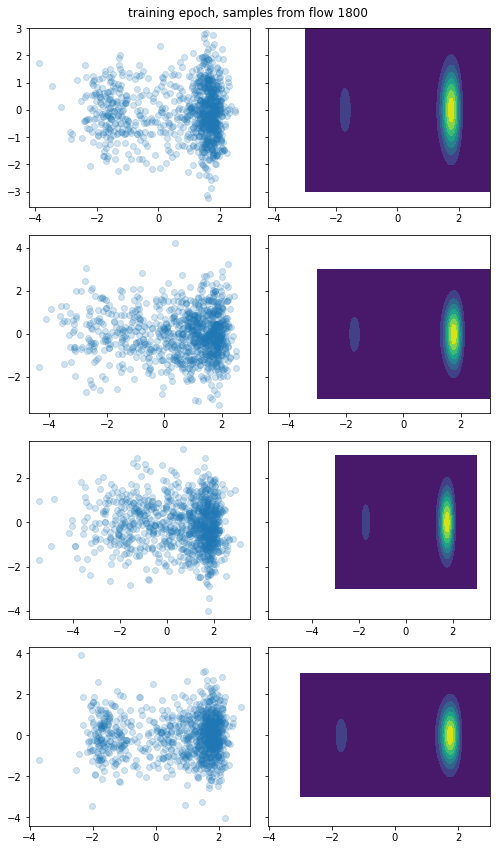

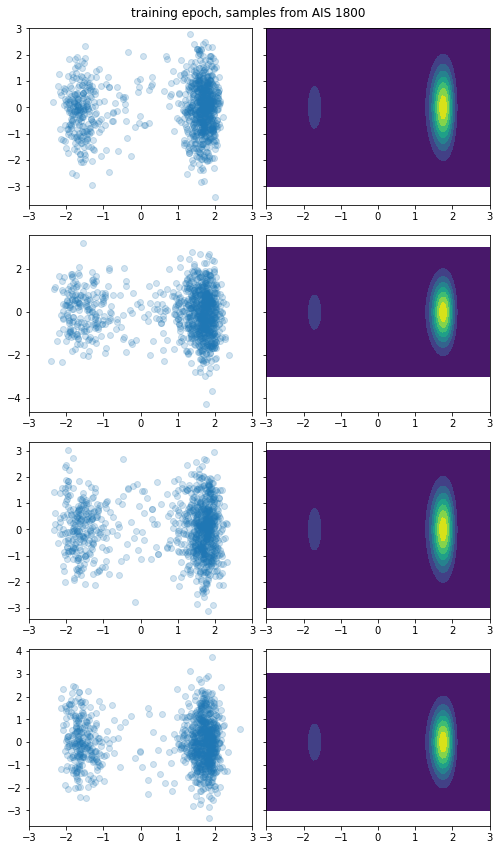

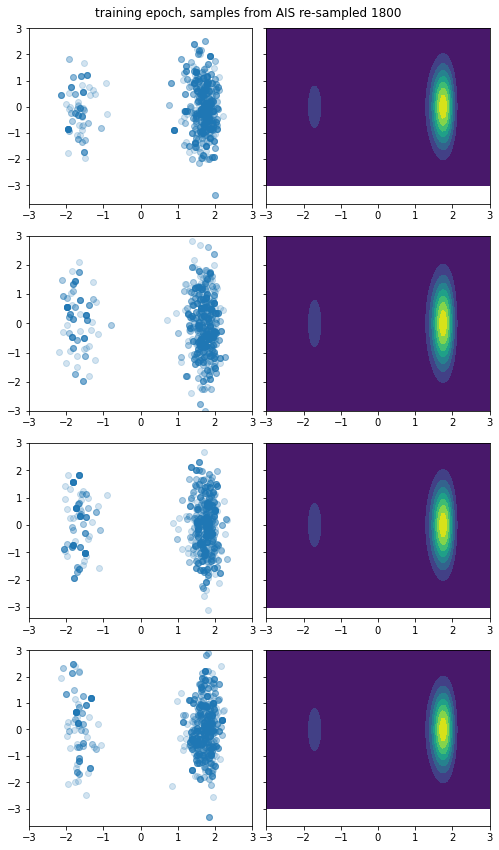

loss: 91.68520025721622,   log_p_x_post_AIS nan, ESS 0.27685764471925467: 100%|██████████| 2000/2000 [6:42:57<00:00, 12.09s/it]


In [12]:
history = tester.train(2000, batch_size=int(1e3), intermediate_plots=True, n_plots=10, plotting_func=plotter)

NaN encountered in log_p_x_after_AIS history
NaN encountered in log_w history


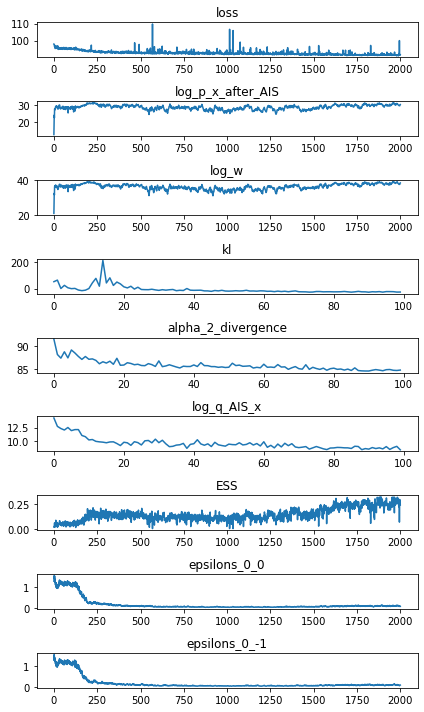

In [13]:
plot_history(history)

NaN encountered in log_p_x_after_AIS history
NaN encountered in log_w history


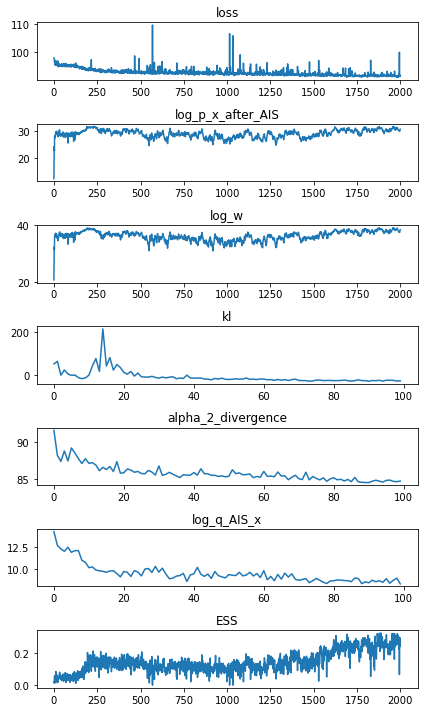

In [14]:
plot_history(dict([(key, history[key]) for key in ('loss', 'log_p_x_after_AIS', 'log_w', 'kl', 
                                               'alpha_2_divergence', 'log_q_AIS_x', 'ESS')]))

In [15]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

nan


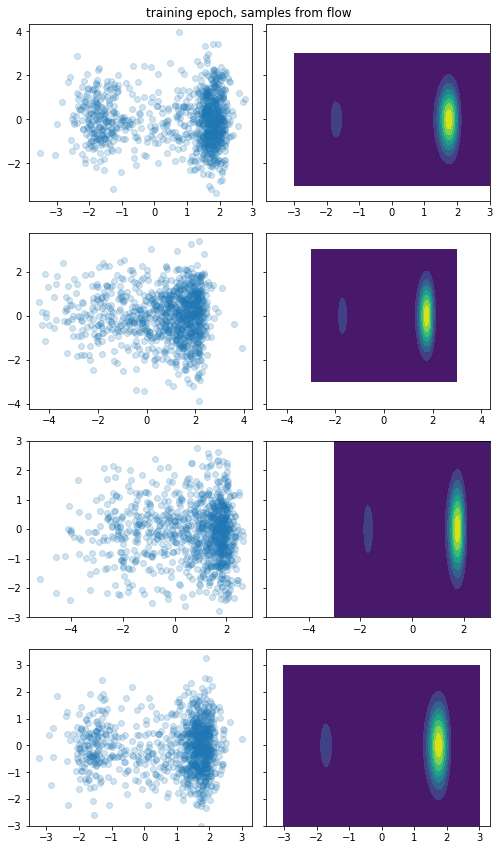

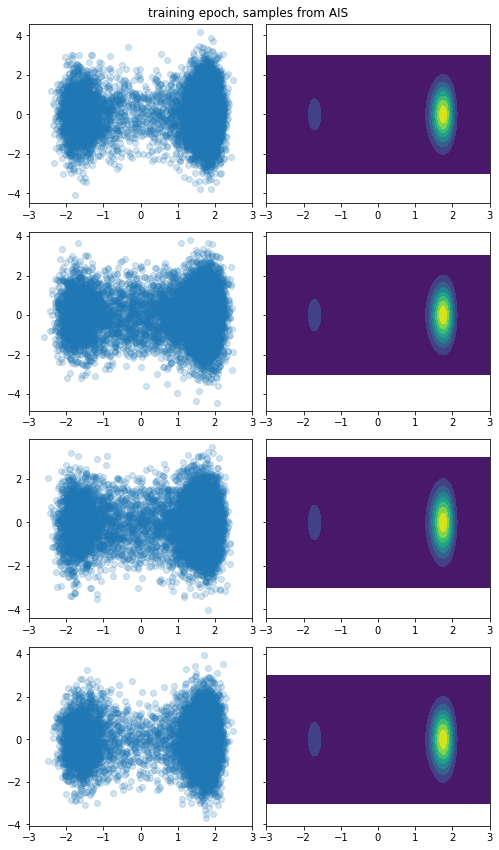

In [16]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

## train more

  0%|          | 0/2000 [00:00<?, ?it/s]

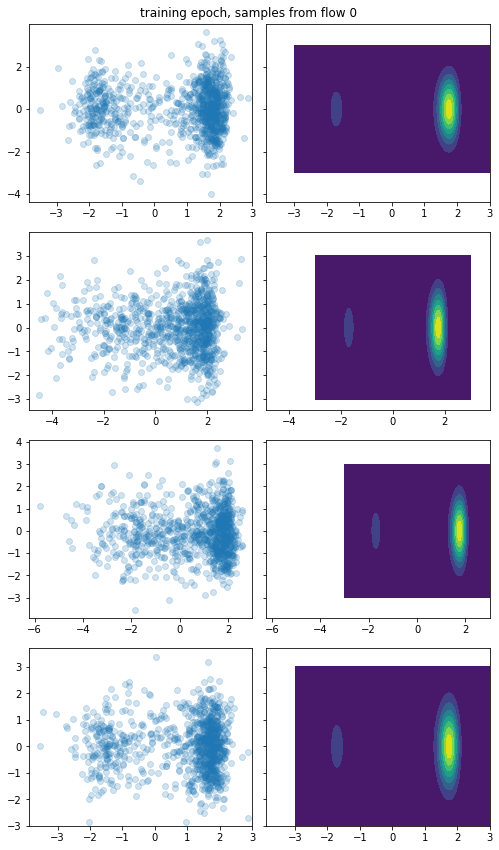

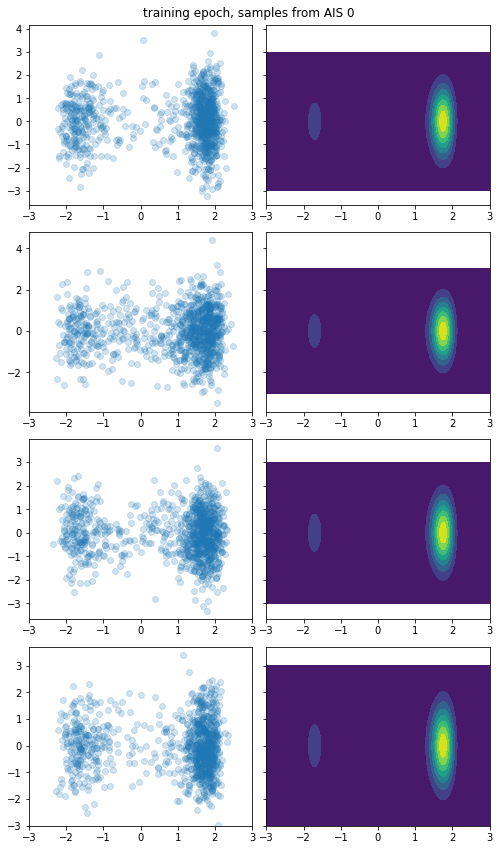

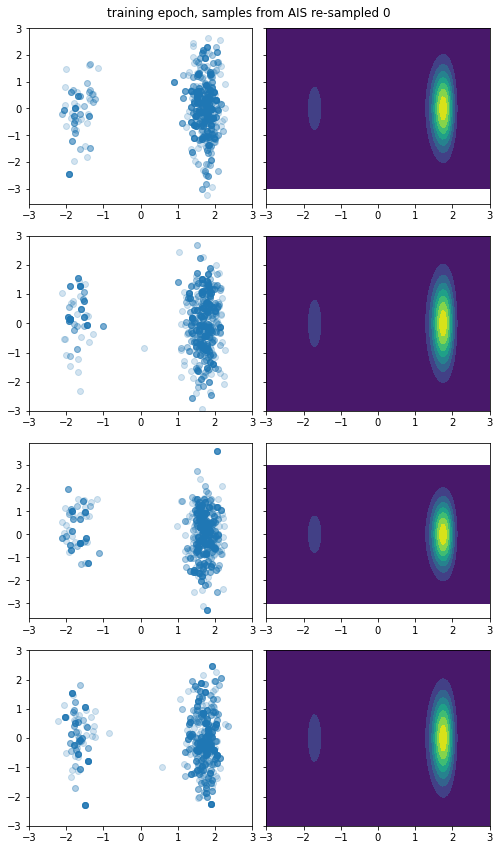

loss: 91.547940213505,   log_p_x_post_AIS nan, ESS 0.23993061759466966:   9%|▊         | 173/2000 [34:03<5:58:20, 11.77s/it] 

In [ ]:
history = tester.train(2000, batch_size=int(1e3), intermediate_plots=True, n_plots=10, plotting_func=plotter)

In [ ]:
plot_history(history)

In [ ]:
plot_history(dict([(key, history[key]) for key in ('loss', 'log_p_x_after_AIS', 'log_w', 'kl', 
                                               'alpha_2_divergence', 'log_q_AIS_x', 'ESS')]))

In [ ]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

In [ ]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])